# Extraindo e Analisando Dados de Vôlei

## Importando pacotes

In [872]:
import scrapy
import requests
from bs4 import BeautifulSoup
import re

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

## Classe responsável pela extração e organização dos dados do site https://www.volleyball24.com

In [887]:
class Volleyball24():
    
    def __init__(self, years, years2):
            
        self.years=years
        self.years2=years2

##################################################################################################################
### Função para extração da lista de países com campeonatos de vôlei #############################################

    def get_country_list(self):
    
        page = requests.get('https://www.volleyball24.com')
        soup = BeautifulSoup(page.text, 'html.parser')
        
        table_countries = soup.find_all(class_="container__overlay")
        
        start = self.get_pos('"MCN":"',str(table_countries[0]))
        end = self.get_pos('","ML"',str(table_countries[0]))
        
        countries=[]
        for i in range(len(start)):
            countries.append(str(table_countries[0])[start[i]:end[i]][7:])
            
        return countries

##################################################################################################################
### Função para extração dos nomes dos campeonatos para cada país ################################################

    def get_champ_list(self, countries):    
        
        all_champs={}
        for country in countries:
            page = requests.get("https://www.volleyball24.com/"+country.lower())
            soup = BeautifulSoup(page.text, 'html.parser')
            champ_table = soup.find_all(class_='container__overlay')
            try:
                start = self.get_pos('class="mbox0px"',str(champ_table[0]))
            except:
                all_champs.append('error')
                continue
            end = self.get_pos('class="adsenvelope adstextpad banx-left_menu_1"',str(champ_table[0]))
            block_countries_champ=str(champ_table[0])[start[0]:end[0]]
            start = self.get_pos('href="/'+country.lower()+'/',block_countries_champ)
            end = self.get_pos('/">',block_countries_champ)
            countries_champ=[]
            for j in range(len(start)):
                countries_champ.append(str(block_countries_champ)[start[j]:end[j]][len('href="/'+country.lower()+'/'):])
            all_champs[country] = countries_champ
            
        return all_champs

##################################################################################################################
### Função para extração de padrões dentro dos html's extraídos ################################################## 

    def get_pos(self, patern,text):
        
        return [m.start() for m in re.finditer(patern, text)]

##################################################################################################################
### Função para extração do id que identifica cada jogo ########################################################## 

    def get_game_ids(self, countries, all_champs):
    
        game_id={}
        for country in countries[:1]:
            temp={}
            for champ in all_champs[country]:
                games_temp={}
                for k in range(len(self.years)):
                    year = self.years[k]
                    # Os links são formados pela url da página + país + campeonato + ano
                    page = requests.get("https://www.volleyball24.com/"+country.lower()+"/"+\
                                        champ.lower()+"-"+year.lower()+"/results/")
                    soup = BeautifulSoup(page.text, 'html.parser')
                    table = soup.find_all(class_='container__livetable')
                    if len(table) == 0:
                        year = self.years2[k]
                        page = requests.get("https://www.volleyball24.com/"+country.lower()+"/"+\
                                            champ.lower()+"-"+year.lower()+"/results/")
                        soup = BeautifulSoup(page.text, 'html.parser')
                        table = soup.find_all(class_='container__livetable')
                    
                    try:
                        start = self.get_pos("AA÷",str(table[0]))
                        if len(start) == 0:
                            continue
                        else:
                            end = self.get_pos("¬AD÷",str(table[0]))
                            games=[]
                            for l in range(len(start)):
                                games.append(str(table[0])[start[l]:end[l]][3:])
                        games_temp[year] = games
                    except:
                        continue
                    print(country,champ,year)
                temp[champ] = games_temp
            game_id[country]  = temp
            
        return game_id

##################################################################################################################
### Função para extração do nome dos times  ######################################################################

    def get_team_names(self, soup):
        try:
            team_home = soup.find_all('div', class_="smh__participantName smh__home")[0].text
            team_away = soup.find_all('div', class_="smh__participantName smh__away")[0].text
            return (team_home,team_away)
        except:
            return 'No team names'

##################################################################################################################
### Função para extração do resultado do jogo ####################################################################
        
    def set_results(self, soup):
        try:
            result_home = soup.find_all('div', class_='smh__part smh__score smh__home smh__part--current')[0].text
            result_away = soup.find_all('div', class_='smh__part smh__score smh__away smh__part--current')[0].text
            result_game = (int(result_home),int(result_away))
            return result_game
        except:
            return 'No set results'

##################################################################################################################
### Função para extração da pontuação de cada set ################################################################
        
    def get_set_results(self, soup, num_sets):
        try:
            #Get results set-by-set
            set_by_set = soup.find_all('div',class_='smh__template volleyball')
            points_sets=[]
            for i in range(1,num_sets+1):
                point_home = int(set_by_set[0].find_all(class_='smh__part smh__home smh__part--'+str(i))[0].text)
                point_away = int(set_by_set[0].find_all(class_='smh__part smh__away smh__part--'+str(i))[0].text)
                points_sets.append((point_home,point_away))
            return points_sets
        except:
            return 'No point sets'

##################################################################################################################
### Função para extração histórico do jogo ponto a ponto  ########################################################
        
    def point_by_point(self, soup):
        try:
            row = soup.find_all('div',class_='matchHistoryRow')
            game_history=[]
            for i in range(len(row)):
                serve0 = row[i].find_all('div',class_='matchHistoryRow__servis matchHistoryRow__home')
                serve1 = row[i].find_all('div',class_='matchHistoryRow__servis matchHistoryRow__away')
                if len(str(serve0[0])) > len(str(serve1[0])):
                    serve = 'home'
                else:
                    serve = 'away'
                point_row = row[i].find_all('div',class_='matchHistoryRow__score')
                game_history.append([serve,int(point_row[0].text),int(point_row[1].text)])
            return game_history
        except:
            return 'No match history'

##################################################################################################################
### Função para extração das odds para apostas  ##################################################################
        
    def get_odds(self, soup):
        try:
            odd_home = float(soup.find_all('span', class_="oddsValueInner")[0].text)
            odd_away = float(soup.find_all('span', class_="oddsValueInner")[1].text)
            odds = (odd_home, odd_away)
            return odds
        except:
            return 'No odds'

##################################################################################################################
### Função para extração da data e horário dos jogos  ############################################################
        
    def get_game_date(self, soup):
        try:
            game_date = soup.find_all('div', class_='duelParticipant__startTime')[0].text
            return game_date
        except:
            return 'No date'

##################################################################################################################
### Função para extração dos dados dos jogos  ####################################################################
        
    def get_summary(self, game_id, country, champ):
        url = "https://www.flashscore.com/match/"+game_id+"/#/match-summary/match-summary"
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.get(url)
        driver.implicitly_wait(10)
        #Accept cookies
        driver.find_element(By.XPATH, value='/html/body/div[3]/div[2]/div/div[1]/div/div[2]/div/button[1]').click()
        
        #Check if the game scores exists
        try:
            driver.find_element(By.XPATH, value='/html/body/div[1]/div/div[9]/div/div[2]/div[4]')
        except:
            try:
                driver.find_element(By.XPATH, value='/html/body/div[1]/div/div[10]/div/div[2]/div[4]')
            except:
                driver.quit()
                return 'No results'
        
        #Get html
        soup = BeautifulSoup(driver.page_source, 'html.parser')
    
        summary={}
        
        team_names = self.get_team_names(soup)
        result_game = self.set_results(soup)
        num_sets = sum(result_game)
        set_scores = self.get_set_results(soup,num_sets)
        odds = self.get_odds(soup)
        game_date = self.get_game_date(soup)
        
        summary['country'] = country
        summary['champ'] = champ
        summary['team_names'] = team_names
        summary['result_game'] = result_game
        summary['num_sets'] = num_sets
        summary['set_scores'] = set_scores
        summary['odds'] = odds
        summary['date'] = game_date
        
        try:
            match_history=[]
            #click on match history
            button = driver.find_element(By.XPATH, value='/html/body/div[1]/div/div[7]/div/a[2]')
            driver.execute_script("arguments[0].click();", button)
            #check if value exists
            driver.find_element(By.XPATH, value='/html/body/div[1]/div/div[9]/div[2]/div[3]')
            soup2 = BeautifulSoup(driver.page_source, 'html.parser')
            match_history.append(self.point_by_point(soup2))
            
            for i in range(1,num_sets):
                try:
                    #click on each set
                    button = driver.find_element(By.XPATH, value='/html/body/div[1]/div/div[8]/a['+str(i+1)+']')
                    driver.execute_script("arguments[0].click();", button)
                    #check if value exists
                    driver.find_element(By.XPATH, value='/html/body/div[1]/div/div[9]/div[2]/div[3]')
                    soup2 = BeautifulSoup(driver.page_source, 'html.parser')
                    match_history.append(self.point_by_point(soup2))
                except:
                    match_history.append('No points')
            
            driver.quit()
            summary['match_history'] = match_history
            
            return summary
        
        except:
            driver.quit()
            summary['match_history'] = 'No match_history: ' + url 
            
            return summary

In [874]:
years = ['2022-2023','2021-2022','2020-2021','2019-2020','2018-2019','2017-2018','2016-2017','2015-2016','2014-2015',\
       '2013-2014','2012-2013','2011-2012','2010-2011','2009-2010','2008-2009']

years2 = ['2022','2021','2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009','2008']


In [889]:
volley = Volleyball24(years, years2)

In [876]:
countries = volley.get_country_list()

In [877]:
print(countries)

['Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'China', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'England', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Latvia', 'Lebanon', 'Montenegro', 'Morocco', 'Netherlands', 'Norway', 'Peru', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'USA', 'Africa', 'Asia', 'Europe', 'North & Central America', 'South America', 'World']


In [878]:
champs = volley.get_champ_list(countries)

In [879]:
champs

{'Argentina': ['lva', 'copa-aclav', 'copa-master', 'liga-women']}

In [880]:
%%time
ids = volley.get_game_ids(countries[:1], champs)

Argentina lva 2022-2023
Argentina lva 2021-2022
Argentina lva 2020-2021
Argentina lva 2019-2020
Argentina lva 2018-2019
Argentina lva 2017-2018
Argentina lva 2016-2017
Argentina lva 2015-2016
Argentina lva 2014-2015
Argentina lva 2013-2014
Argentina lva 2012-2013
Argentina lva 2011-2012
Argentina lva 2010-2011
Argentina lva 2009-2010
Argentina copa-aclav 2022
Argentina copa-aclav 2021
Argentina copa-aclav 2020
Argentina copa-aclav 2019
Argentina copa-aclav 2018
Argentina copa-aclav 2017
Argentina copa-aclav 2016
Argentina copa-aclav 2015
Argentina copa-aclav 2014
Argentina copa-aclav 2013
Argentina copa-master 2022
Argentina copa-master 2021
Argentina copa-master 2019
Argentina copa-master 2018
Argentina copa-master 2017
Argentina copa-master 2016
Argentina copa-master 2015
Argentina copa-master 2014
Argentina copa-master 2013
Argentina liga-women 2022
Argentina liga-women 2021
Argentina liga-women 2020
Argentina liga-women 2019
CPU times: user 7.77 s, sys: 214 ms, total: 7.99 s
Wall t

In [881]:
ids['Argentina']['lva']['2022-2023'][0]

'C4k0Gp6g'

In [890]:
id_ = ids['Argentina']['lva']['2022-2023'][0]
summary = volley.get_summary(id_, 'Argentina', 'lva')

/tmp/ipykernel_783179/326910796.py:188: DeprecationWarning:

executable_path has been deprecated, please pass in a Service object



In [891]:
summary.keys()

dict_keys(['country', 'champ', 'team_names', 'result_game', 'num_sets', 'set_scores', 'odds', 'date', 'match_history'])

### Para fazer o download de todos os jogos basta fazer um loop sobre todos os ids. Pode demorar alguns dias para que todos os jogos sejam extraídos.

## Breve análise da diferença entre times da casa e times visitantes

### Importação e limpeza dos dados

In [892]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
data = pd.read_pickle('volley.pkl')

In [893]:
len(data)

143025

#### Dados até o início do ano de 2022

In [894]:
data.set_index('index').head()

,home,alway,championship,date,result,number_of_sets,set_results,point_by_point
index,,,,,,,,
0,Cameroon,Tunisia,AFRICA: African Championship - Play Offs - Final,14.09.2021 13:00,"[1, 3]",4,"[[25, 16], [21, 25], [21, 25], [16, 25]]","[[[home, 1, 0], [home, 2, 0], [home, 2, 1], [a..."
1,Mali,Kenya,AFRICA: African Championship - 9th-16th places...,14.09.2021 10:00,"[0, 3]",3,"[[21, 25], [21, 25], [16, 25]]","[[[away, 0, 1], [away, 0, 2], [away, 0, 3], [a..."
2,Morocco,Egypt,AFRICA: African Championship - Play Offs - 3rd...,14.09.2021 10:00,"[1, 3]",4,"[[25, 23], [26, 28], [21, 25], [18, 25]]",no data
3,Burundi,Niger,AFRICA: African Championship - 9th-16th places...,14.09.2021 08:00,"[3, 1]",4,"[[15, 25], [25, 23], [25, 22], [25, 21]]","[[[home, 1, 0], [home, 1, 1], [away, 1, 2], [a..."
4,Rwanda,Uganda,AFRICA: African Championship - 5th-8th places ...,14.09.2021 06:30,"[1, 3]",4,"[[25, 21], [23, 25], [20, 25], [13, 25]]","[[[home, 0, 1], [away, 1, 1], [home, 2, 1], [h..."


#### Eliminando resultados impossíveis 

In [269]:
possible_results = [[3,0],[3,1],[3,2],[0,3],[1,3],[2,3]]

data1 = data[data.result.isin(possible_results)].copy()

In [270]:
# Criando coluna identificando o time vencedor
data1['winner'] = data1.result.apply(lambda x: 'home' if x in [[3,0],[3,1],[3,2]] else 'away')

In [271]:
def f(x):
    if x==[3,0] or x==[0,3]:
        return [3,0]
    if x==[3,1] or x==[1,3]:
        return [3,1]
    if x==[3,2] or x==[2,3]:
        return [3,2]

In [272]:
data1['new_result'] = data1.result.apply(lambda x: f(x))
data1['new_result'] = data1.new_result.apply(lambda x: str((x[0],x[1])))

#### Contagem da quantidade de jogos vencidos pelo time da casa e pelo time visitante para cada resultado possível

In [282]:
temp = data1.groupby(['new_result','winner'])['result'].agg('count')

In [283]:
temp

new_result  winner
(3, 0)      away      27938
            home      40838
(3, 1)      away      20092
            home      24768
(3, 2)      away      13882
            home      14899
Name: result, dtype: int64

In [284]:
temp2=pd.DataFrame(temp).reset_index()

In [326]:
temp2

,new_result,winner,result
0,"(3, 0)",away,27938
1,"(3, 0)",home,40838
2,"(3, 1)",away,20092
3,"(3, 1)",home,24768
4,"(3, 2)",away,13882
5,"(3, 2)",home,14899


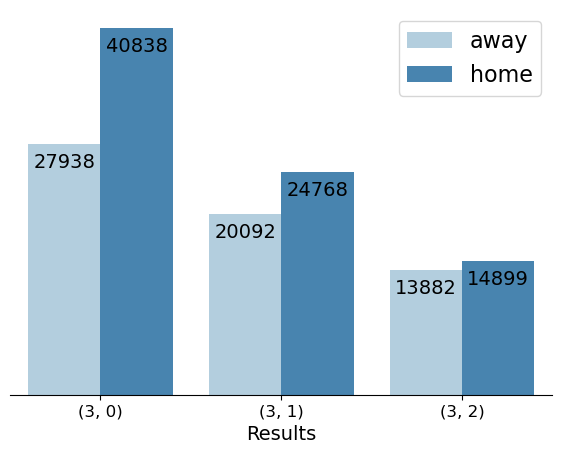

In [303]:
fig, ax = plt.subplots(figsize = (7, 5))

splot = sns.barplot(data=temp2, x="new_result", y="result", hue="winner", palette='Blues')

for g in splot.patches:
    splot.annotate(int(g.get_height()),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -13),
                   textcoords = 'offset points',
                  size=14)
plt.xlabel("Results", size = 14)
plt.ylabel("Count", size = 14, visible=False)
plt.legend(fontsize=16)
plt.tick_params(axis='x', labelrotation=0)

plt.tick_params(axis='both', which='major', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False, right = False , labelleft = False)
plt.show()

### Podemos ver que o time da casa tende a vencer mais. No entanto a diferença parece diminuir quando o jogo dura mais sets, indicando que para times mais equilibrados em força a vantagem de jogar em casa não é tão significante.

In [430]:
def get_diff(data, n_sets, winner='home'):
    
    diff = data[data.number_of_sets==n_sets].set_results.apply(lambda x: [r[0]-r[1] for r in x]).apply(pd.Series, dtype=float)
    if n_sets==3:
        if winner == 'all':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)]
        if winner == 'home':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(diff[2]>0)]
        if winner == 'away':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(diff[2]<0)]
    if n_sets==4:
        if winner == 'all':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(abs(diff[3])<25)]
        if winner == 'home':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(abs(diff[3])<25)&(diff[3]>0)]
        if winner == 'away':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(abs(diff[3])<25)&(diff[3]<0)]
    if n_sets==5:
        if winner == 'all':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(abs(diff[3])<25)&(abs(diff[4])<25)]
        if winner == 'home':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(abs(diff[3])<25)&(abs(diff[4])<25)&(diff[4]>0)]
        if winner == 'away':
            diff = diff[(abs(diff[0])<25)&(abs(diff[1])<25)&(abs(diff[2])<25)&(abs(diff[3])<25)&(abs(diff[4])<25)&(diff[4]<0)]

    return diff

In [439]:
def box_plot(data, winner='all'):    
    diff3 = get_diff(data, n_sets=3, winner=winner)
    diff4 = get_diff(data, n_sets=4, winner=winner)
    diff5 = get_diff(data, n_sets=5, winner=winner)
    
    fig, axs = plt.subplots(1,3,figsize = (15, 5))
    
    medians = diff3.median()
    #vertical_offset = tips['total_bill'].median() * 0.05
    
    bp3 = sns.boxplot(data=diff3, ax=axs[0])
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[0].set_title('3 - 0', fontsize=14)
    axs[0].set_ylabel('Point Difference (home - away)', fontsize=14)
    for xtick in bp3.get_xticks():
        bp3.text(xtick,medians[xtick] + 0.5,medians[xtick], 
                horizontalalignment='center',color='w',weight='semibold', fontsize=12)
    axs[0].set_xticklabels(['set 1', 'set 2','set 3'])
    axs[0].tick_params(axis='x', labelrotation=45)
    
    medians = diff4.median()
    
    bp4 = sns.boxplot(data=diff4, ax=axs[1])
    axs[1].tick_params(axis='both', which='major', labelsize=12)
    axs[1].set_title('3 - 1', fontsize=14)
    for xtick in bp4.get_xticks():
        bp4.text(xtick,medians[xtick] + 0.5,medians[xtick], 
                horizontalalignment='center', fontsize=12,color='w',weight='semibold')
    axs[1].set_xticklabels(['set 1', 'set 2','set 3','set4'])
    axs[1].tick_params(axis='x', labelrotation=45)
    
    medians = diff5.median()
    
    bp5 = sns.boxplot(data=diff5, ax=axs[2])
    axs[2].tick_params(axis='both', which='major', labelsize=11)
    axs[2].set_title('3 - 2', fontsize=14)
    for xtick in bp5.get_xticks():
        bp5.text(xtick,medians[xtick] + 0.5,medians[xtick], 
                horizontalalignment='center', fontsize=12,color='w',weight='semibold')
    axs[2].set_xticklabels(['set 1', 'set 2','set 3','set4','set5'])
    axs[2].tick_params(axis='x', labelrotation=45)
    
    #sns.boxplot(data=diff[abs(diff[1])<25], y=1)
    plt.suptitle(winner, fontsize=18)

    plt.show()

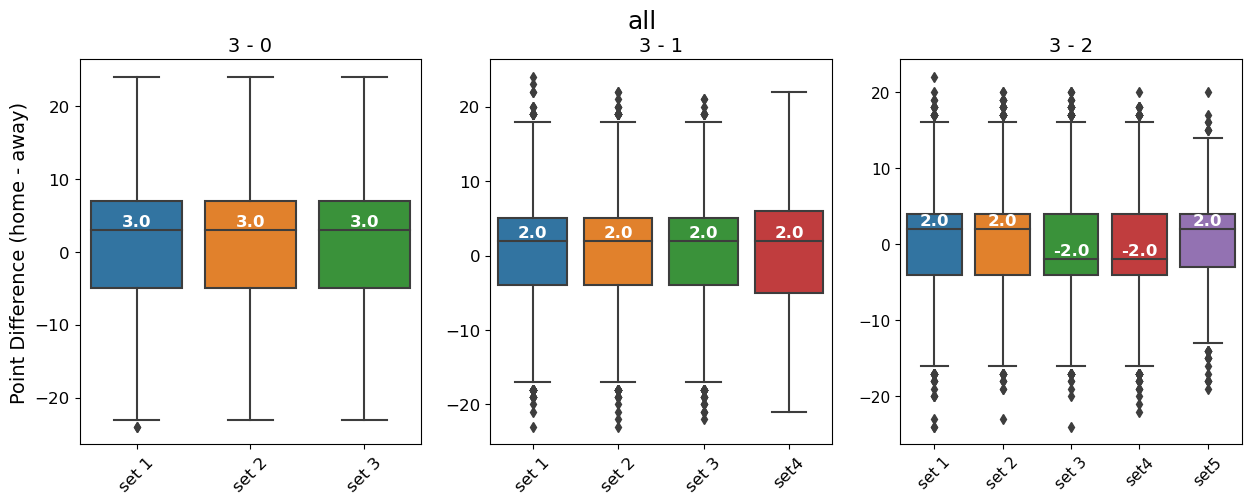

In [440]:
box_plot(data, winner='all')

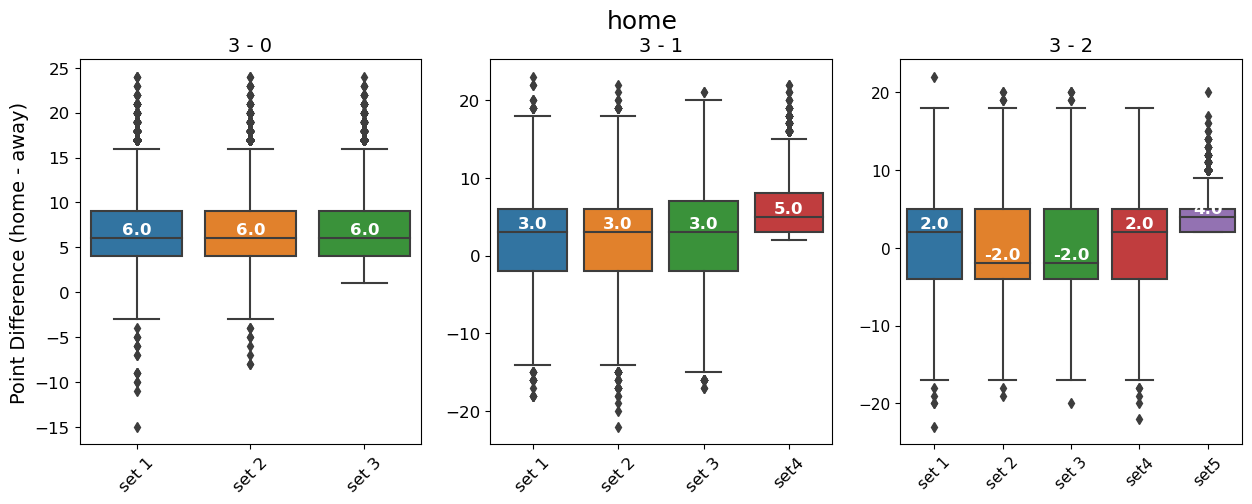

In [441]:
box_plot(data, winner='home')

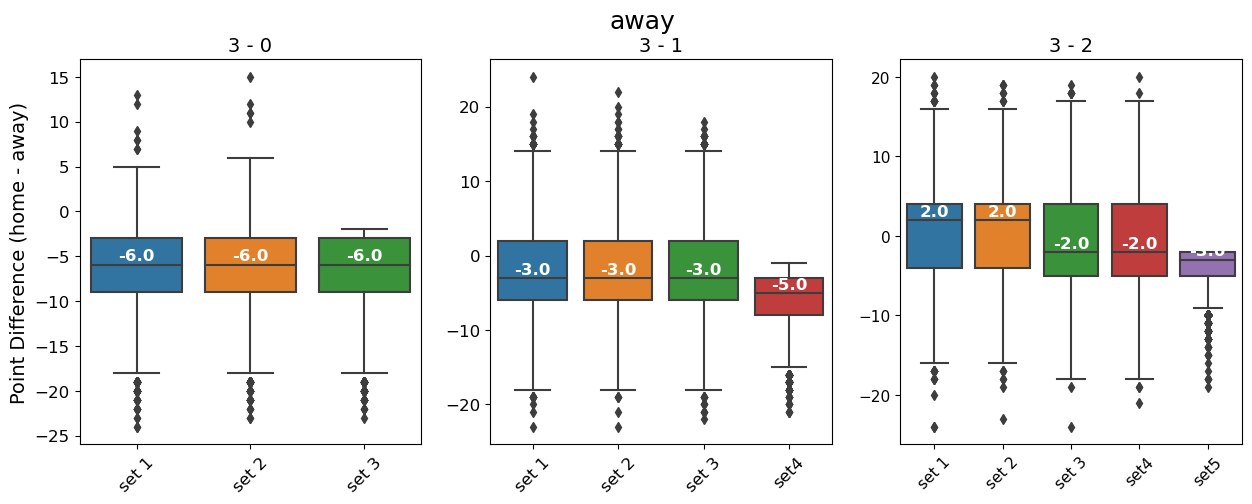

In [442]:
box_plot(data, winner='away')

### Diferença de pontos em cada set para placares diferentes e para o time da casa e visitante separadamente.

In [738]:
data_set1 = data1[(data1.point_by_point != 'no data') 
                  & (data1.number_of_sets==3) 
                  & (data1.winner=='home')
                 ]

data_set2 = data1[(data1.point_by_point != 'no data') 
                  & (data1.number_of_sets==3) 
                  & (data1.winner=='away')
                 ]

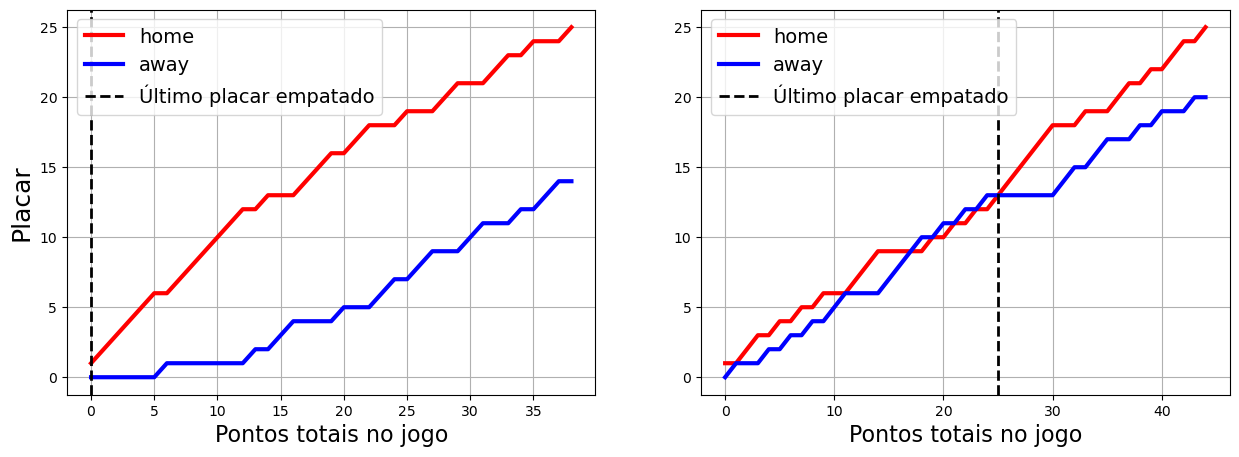

In [762]:
fig, axs = plt.subplots(1,2,figsize = (15, 5))

g=5
x1 = np.arange(len([i[1] for i in data_set1['point_by_point'].values[g][0]]))
y1 = [i[1] for i in data_set1['point_by_point'].values[g][0]]

x2 = np.arange(len([i[2] for i in data_set1['point_by_point'].values[g][0]]))
y2 = [i[2] for i in data_set1['point_by_point'].values[g][0]]
sns.lineplot(x=x1, y=y1, color = 'r', lw=3, ax=axs[0], label='home')
sns.lineplot(x=x2, y=y2, color = 'b', lw=3, ax=axs[0], label='away')
axs[0].axvline(0, 0,25, ls='--', color='k', lw=2, label='Último placar empatado')
axs[0].set_ylabel('Placar', fontsize=18)
axs[0].set_xlabel('Pontos totais no jogo', fontsize=16)
axs[0].legend(loc='best', fontsize=14)
axs[0].grid(True)

g=6
x1 = np.arange(len([i[1] for i in data_set1['point_by_point'].values[g][0]]))
y1 = [i[1] for i in data_set1['point_by_point'].values[g][0]]

x2 = np.arange(len([i[2] for i in data_set1['point_by_point'].values[g][0]]))
y2 = [i[2] for i in data_set1['point_by_point'].values[g][0]]
sns.lineplot(x=x1, y=y1, color = 'r', lw=3, ax=axs[1], label='home')
sns.lineplot(x=x2, y=y2, color = 'b', lw=3, ax=axs[1], label='away')
axs[1].axvline(25, 0,25, ls='--', color='k', lw=2, label='Último placar empatado')
axs[1].set_xlabel('Pontos totais no jogo', fontsize=16)
axs[1].legend(loc='best', fontsize=14)
axs[1].grid(True)
    #plt.plot([i[2] for i in data_set1['point_by_point'].values[3][0]])

### Acima está mostrado o conceito que do que será calculado abaixo. O último ponto em que ocorreu empate antes de um time abrir a vantagem e ganhar o set. À esquerda vemos isso acontecendo desde o primeiro ponto e à direita isso ocorre no ponto 26 do jogo, ou seja 13 x 13. 

In [519]:
from more_itertools import locate

def find_indices(list_to_check, item_to_find):
    indices = locate(list_to_check, lambda x: x == item_to_find)
    return list(indices)

In [705]:
def get_max_id(data_set1, num_sets):  
    max_id = []
    for m in range(num_sets):
        temp = []
        for n in range(len(data_set1)):
            if len(data_set1['point_by_point'].values[n]) == num_sets:
                diff_points = [i[1] - i[2] for i in data_set1['point_by_point'].values[n][m]]
                id_ = find_indices(diff_points, 0)
                if len(id_) > 0:
                    temp.append(max(id_))
                else:
                    temp.append(1)
        max_id.append(temp)
    return max_id

In [906]:
def plot_last_tied_point(winner='home', num_sets=3, ax=ax):  
    
    data_set1 = data1[(data1.point_by_point != 'no data') 
                      & (data1.number_of_sets==num_sets) 
                      & (data1.winner==winner)
                     ]
    
    colors = {0:'red',
              1:'blue',
              2:'green',
              3:'yellow',
              4:'brown'}
    title = {3:'3 - 0',
             4:'3 - 1',
             5:'3 - 2'}
    
    max_id = get_max_id(data_set1, num_sets)
    for i in range(num_sets):
        sns.histplot(x=max_id[i], kde=True, color='gray', alpha=0.2, palette='pastel',stat="density", element="step",ax=ax) 
        sns.kdeplot(x=max_id[i], color=colors[i], lw=2, ls='--', label = 'set'+str(i+1), ax=ax)
        ax.set_xlim(0,85)
        ax.axvline(np.mean(max_id[i]), 0,1, ls='-.', color=colors[i], lw=2, label='media = '+str(round(np.mean(max_id[i]),2)))

        ax.legend(loc='best', fontsize=14)
        ax.set_ylabel('Density', fontsize=16)
    
    ax.set_xlabel('Último ponto de empate', fontsize=14)
    ax.set_title(title[num_sets] + ' (' + winner.upper() + ')')

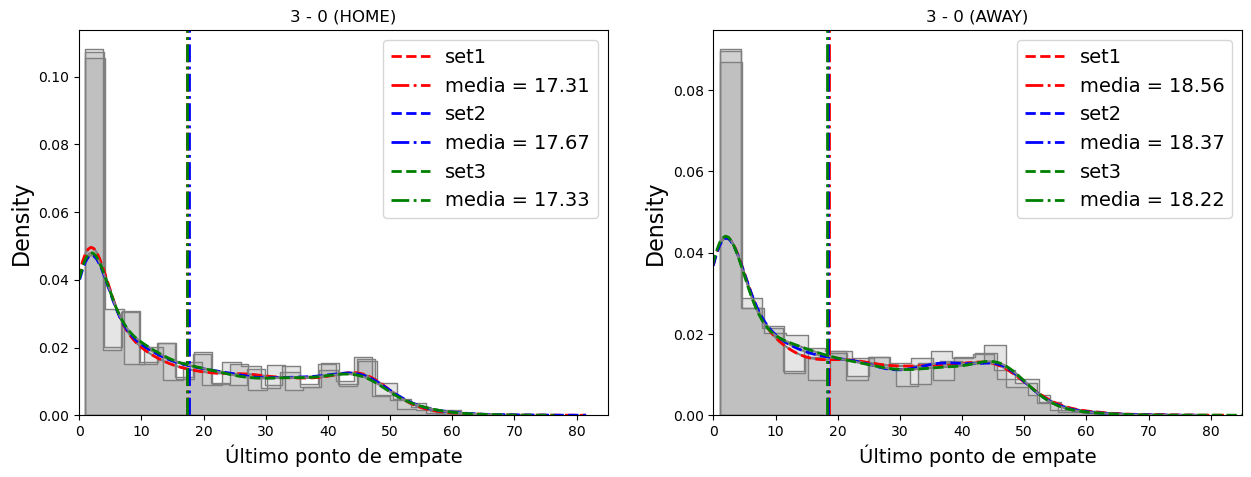

In [907]:
fig, axs = plt.subplots(1,2,figsize = (15, 5))
plot_last_tied_point(winner='home', num_sets=3, ax=axs[0])
plot_last_tied_point(winner='away', num_sets=3, ax=axs[1])

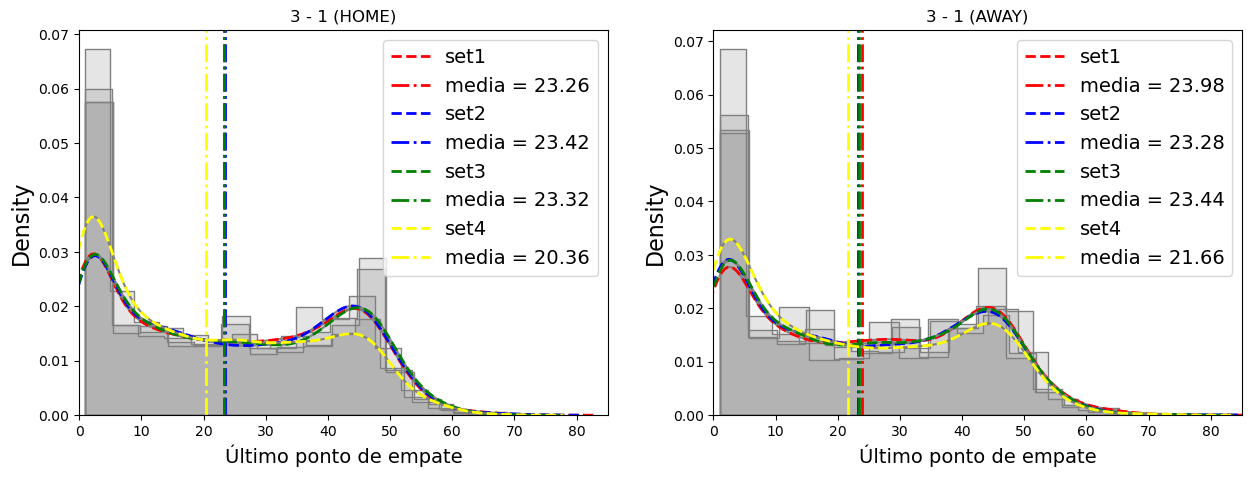

In [908]:
fig, axs = plt.subplots(1,2,figsize = (15, 5))
plot_last_tied_point(winner='home', num_sets=4, ax=axs[0])
plot_last_tied_point(winner='away', num_sets=4, ax=axs[1])

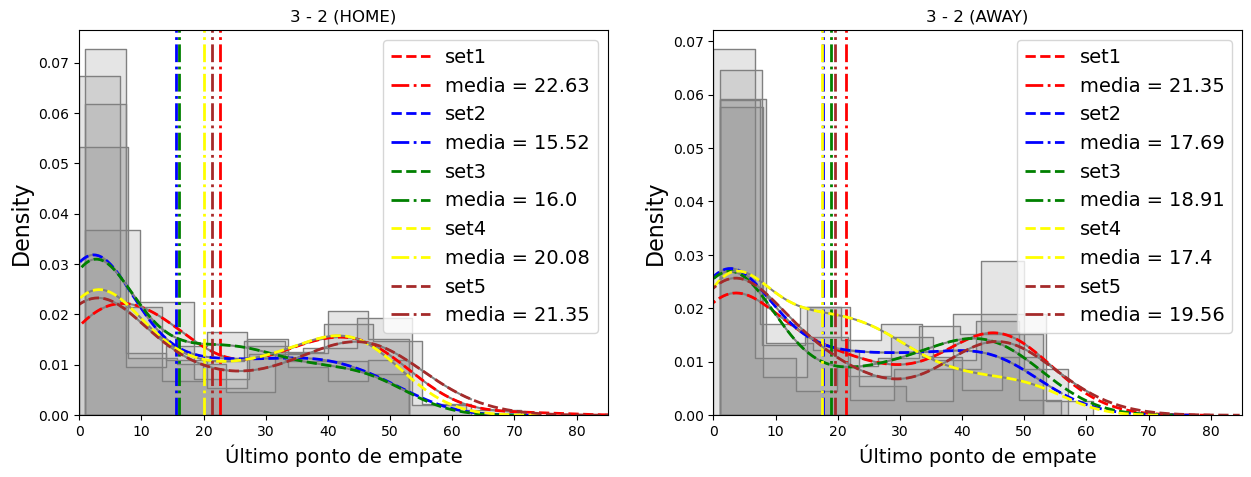

In [909]:
fig, axs = plt.subplots(1,2,figsize = (15, 5))
plot_last_tied_point(winner='home', num_sets=5, ax=axs[0])
plot_last_tied_point(winner='away', num_sets=5, ax=axs[1])

### Aqui vemos a distribuição do ponto do jogo em que um time abriu vantagem e não foi mais alcançado. Vemos que a média em que isso acontece nos jogos 3 - 0 é menor do que nos outros jogos, mostrando que, em geram, o time vencedor abre a vantagem mais cedo. Também notamos um leve pico próximo do ponto 48, o que indica os jogos mais disputados, que seguem empatados até próximo dos 25 pontos do final de cada set. 

In [840]:
def point_sequence(num_sets=3, winner='home', set_ = 0, points_to_look = 'home'):    
    points = []
    data_set1 = data1[(data1.point_by_point != 'no data') 
                          & (data1.number_of_sets==num_sets) 
                          & (data1.winner==winner)
                         ]
    for j in range(len(data_set1)):    
        try:
            for i in data_set1['point_by_point'].values[j][set_]:
                if i[0] == points_to_look:
                    points.append(1)
                else:
                    points.append(0)
        except:
            continue
            
    count=1
    seq=[]
    for i in points:
        if i == 0:
            seq.append(count)
            count = 1
            continue
        count+=1
        
    return seq

Text(0.5, 1.0, 'Away')

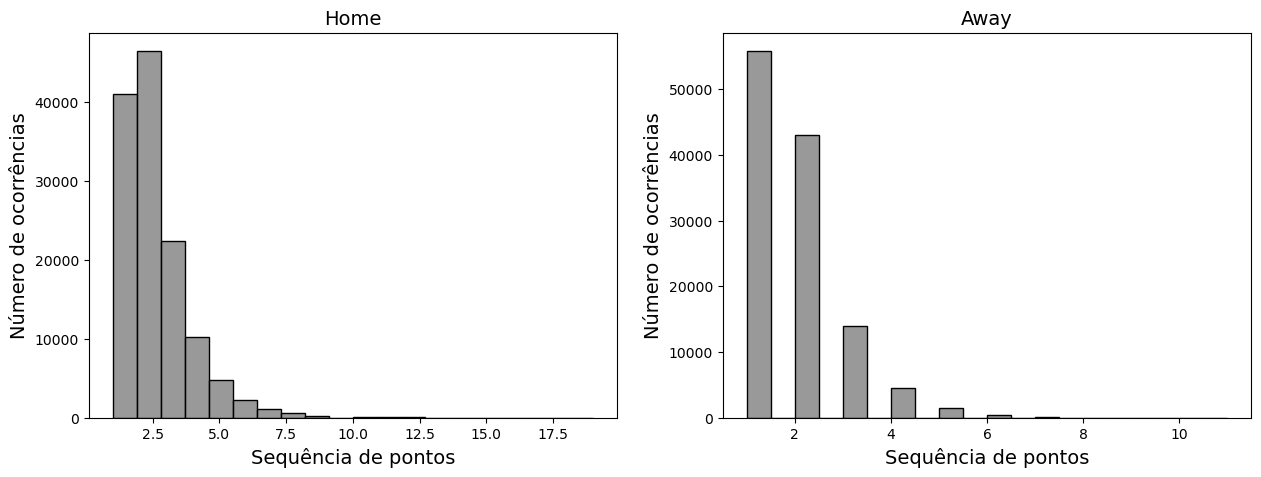

In [903]:
fig, axs = plt.subplots(1,2,figsize = (15, 5))


n_sets=3
for i in range(1, n_sets-1):
    seq = point_sequence(num_sets=n_sets, winner='home',  set_=i, points_to_look = 'home')
    sns.histplot(x=seq, kde=False, color='gray', alpha=0.8, palette='pastel', bins=20, ls='-', ax=axs[0]) 
axs[0].set_xlabel('Sequência de pontos', fontsize=14)
axs[0].set_ylabel('Número de ocorrências', fontsize=14)
axs[0].set_title('Home', fontsize=14)

n_sets=3
for i in range(1, n_sets-1):
    seq = point_sequence(num_sets=n_sets, winner='away',  set_=i, points_to_look = 'home')
    sns.histplot(x=seq, kde=False, color='gray', alpha=0.8, palette='pastel', bins=20, ls='-', ax=axs[1]) 
axs[1].set_xlabel('Sequência de pontos', fontsize=14)
axs[1].set_ylabel('Número de ocorrências', fontsize=14)
axs[1].set_title('Away', fontsize=14)


### Podemos ver que quando o time da casa ganha há uma ocorrência um pouco maior de sequências de dois pontos do que pontos isolados. 